# Quantization and Deployment on Greenwaves GAP8

 

The first notebook applied a HW-independent optimization oriented at reducing the memory occupation of the model. In this second part, we apply a further set of optimizations. Since we're getting closer to the final deployment, we have to decide a HW target (the sooner this decision is made the better, in general). In this example, we'll target **GAP8**, a recent design by Arm which includes a microNPU accelerator as well as a Cortex CPU.

Note that this HW target can also be emulated using [Virtual Hardware](https://github.com/pulp-platform/gvsoc), which allows you to deploy the model and test it without having the real chip on your hands. You can try it if you like. Free local installations of the virtual platform are available. We'll skip that part just for sake of time.

### Overview

This notebook contains the following sections:

- Training of the architecture found in the previous part using PLiNIO (**NOTE**: we load it here the model trained in the other notebook)
- Application of the last NAS present in PLiNIO for Mixed-Precision Selection (MPS)
- Exploration of the architecture found
- Training to force 8bits weights and activation
- Export with a format compatible with with GAP8 Deployment toolchain

We are here:

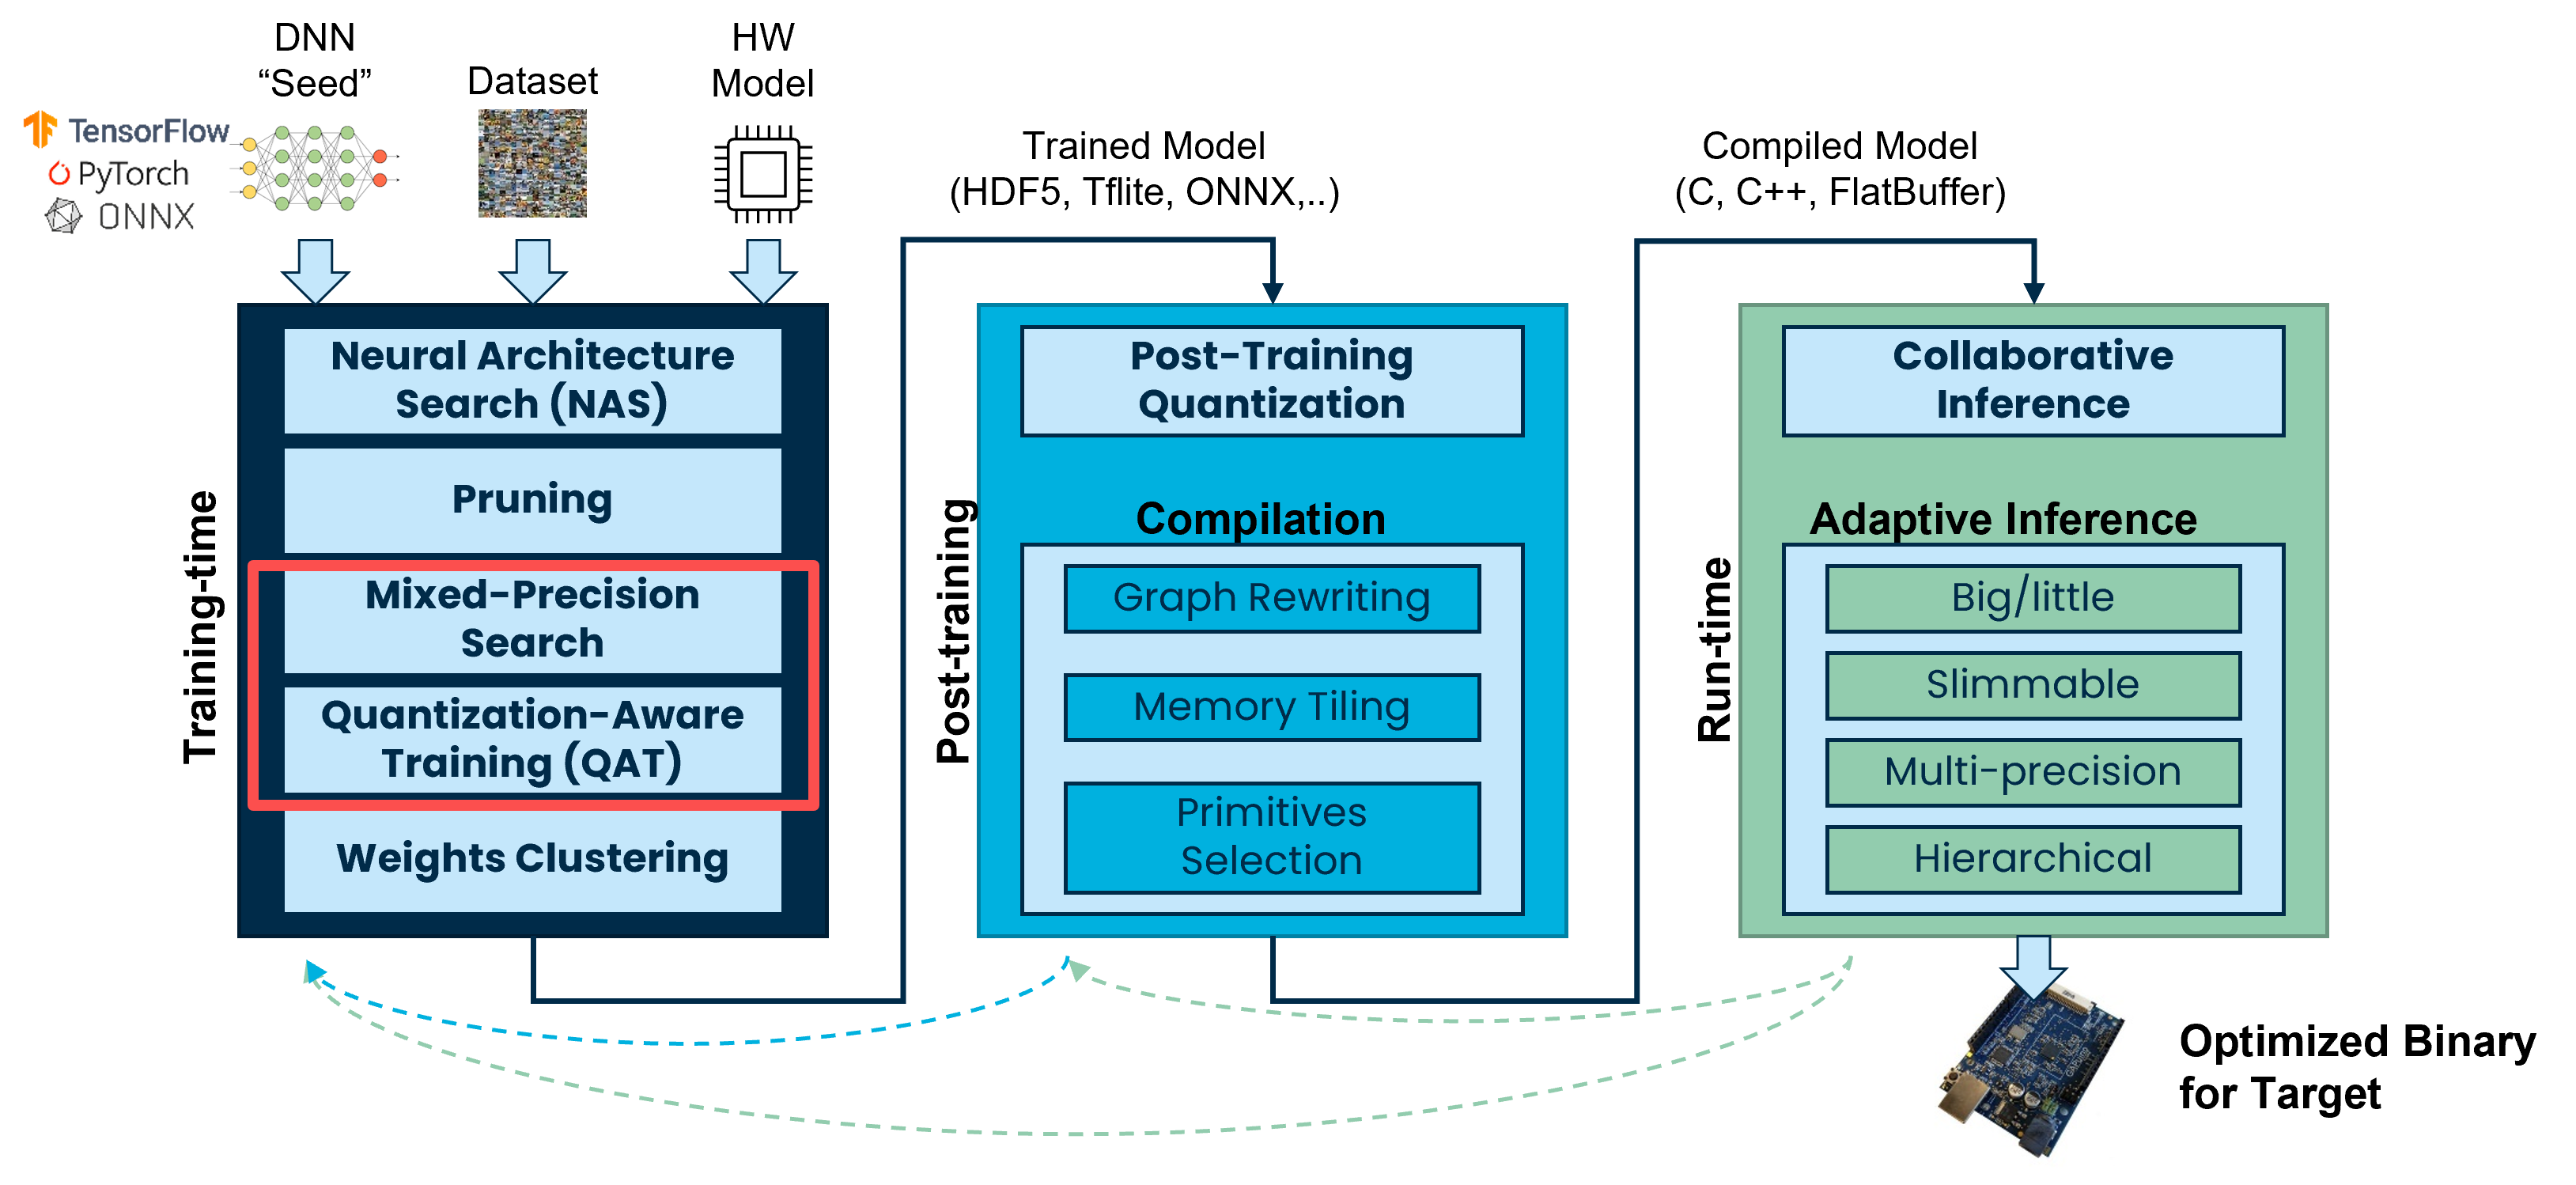

### Environment setup
Let's start with some imports. 
- we use torch library for these experiments;
- for MPS search we use plinio, which also contains a gradient-based MPS algorithm.

In [1]:
!git clone https://github.com/eml-eda/plinio.git
!git clone https://github.com/eml-eda/pytorch-benchmarks.git
!git clone https://github.com/ABurrello/material-oenne.git
!python3 -m pip install plinio/.
!python3 -m pip install pytorch-benchmarks/.
!python3 -m pip install pytorch_model_summary
!python3 -m pip install torchinfo
!python3 -m pip install onnx

Cloning into 'plinio'...
remote: Enumerating objects: 3111, done.
remote: Counting objects: 100% (1066/1066), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 3111 (delta 790), reused 1022 (delta 764), pack-reused 2045
Receiving objects: 100% (3111/3111), 7.09 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (2101/2101), done.
Cloning into 'pytorch-benchmarks'...
remote: Enumerating objects: 432, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 432 (delta 129), reused 161 (delta 78), pack-reused 201
Receiving objects: 100% (432/432), 161.61 KiB | 9.51 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Cloning into 'material-oenne'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 70 (delta 15), reused 69 (delta 14), pack-reused 0
Unpacking objects: 100% (70/70), 19.57 MiB | 8.31 MiB/s, done.
Look

Import the packages necessary for MPS search

In [2]:
import pathlib
from typing import Dict

from pytorch_model_summary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from plinio.methods import MixPrec
from plinio.methods.mixprec.nn import MixPrecType
from plinio.methods.mixprec.nn.mixprec_qtz import MixPrec_Qtz_Layer
import pytorch_benchmarks.image_classification as icl
from pytorch_benchmarks.utils import CheckPoint, EarlyStopping

In [3]:
# Check CUDA availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# Get the Data
datasets = icl.get_data(perf_samples=False)
dataloaders = icl.build_dataloaders(datasets)
train_dl, val_dl, test_dl = dataloaders
input_example = torch.unsqueeze(datasets[0][0][0], 0).to(device)
input_shape = datasets[0][0][0].numpy().shape


Training on: cuda:0


100%|██████████| 170498071/170498071 [00:12<00:00, 13205981.35it/s]


Extracting /content/icl_data/cifar-10-python.tar.gz to /content/icl_data
Files already downloaded and verified


Loading the model obtained from the previous notebook.

In [4]:
model = torch.load("material-oenne/models/PIT_Supernet.pt")
print(summary(model, input_example, show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       MaxPool2d-1     [1, 16, 16, 16]               0               0
       MaxPool2d-2       [1, 32, 8, 8]               0               0
       MaxPool2d-3       [1, 64, 4, 4]               0               0
       MaxPool2d-4      [1, 234, 1, 1]               0               0
          Linear-5             [1, 10]           2,350           2,350
Total params: 2,350
Trainable params: 2,350
Non-trainable params: 0
-----------------------------------------------------------------------


================================================= Hierarchical Summary =================================================

GraphModule(
  (block1): Module(
    (conv1): Module(
      (sn_input_layers): Module(
        (0): Module(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 448 params
          (0_exported_bn): BatchNorm2d

Guess what? It still obtains xxx% accuracy as in the other notebook :-)

In [5]:
criterion = icl.get_default_criterion()
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Test Loss: 0.6925619840621948, Test Acc: 75.87999725341797


## Quantization

As GAP8 only supports 8-bit operation, our model **must be quantized** before deployment.

We have two possible strategies here:

1. We can apply **Quantization-aware Training (QAT)** to the original floating point model, throwing away the results of weights clustering, or...

1. We can quantize it with **Post-Training Quantization (PTQ)**.


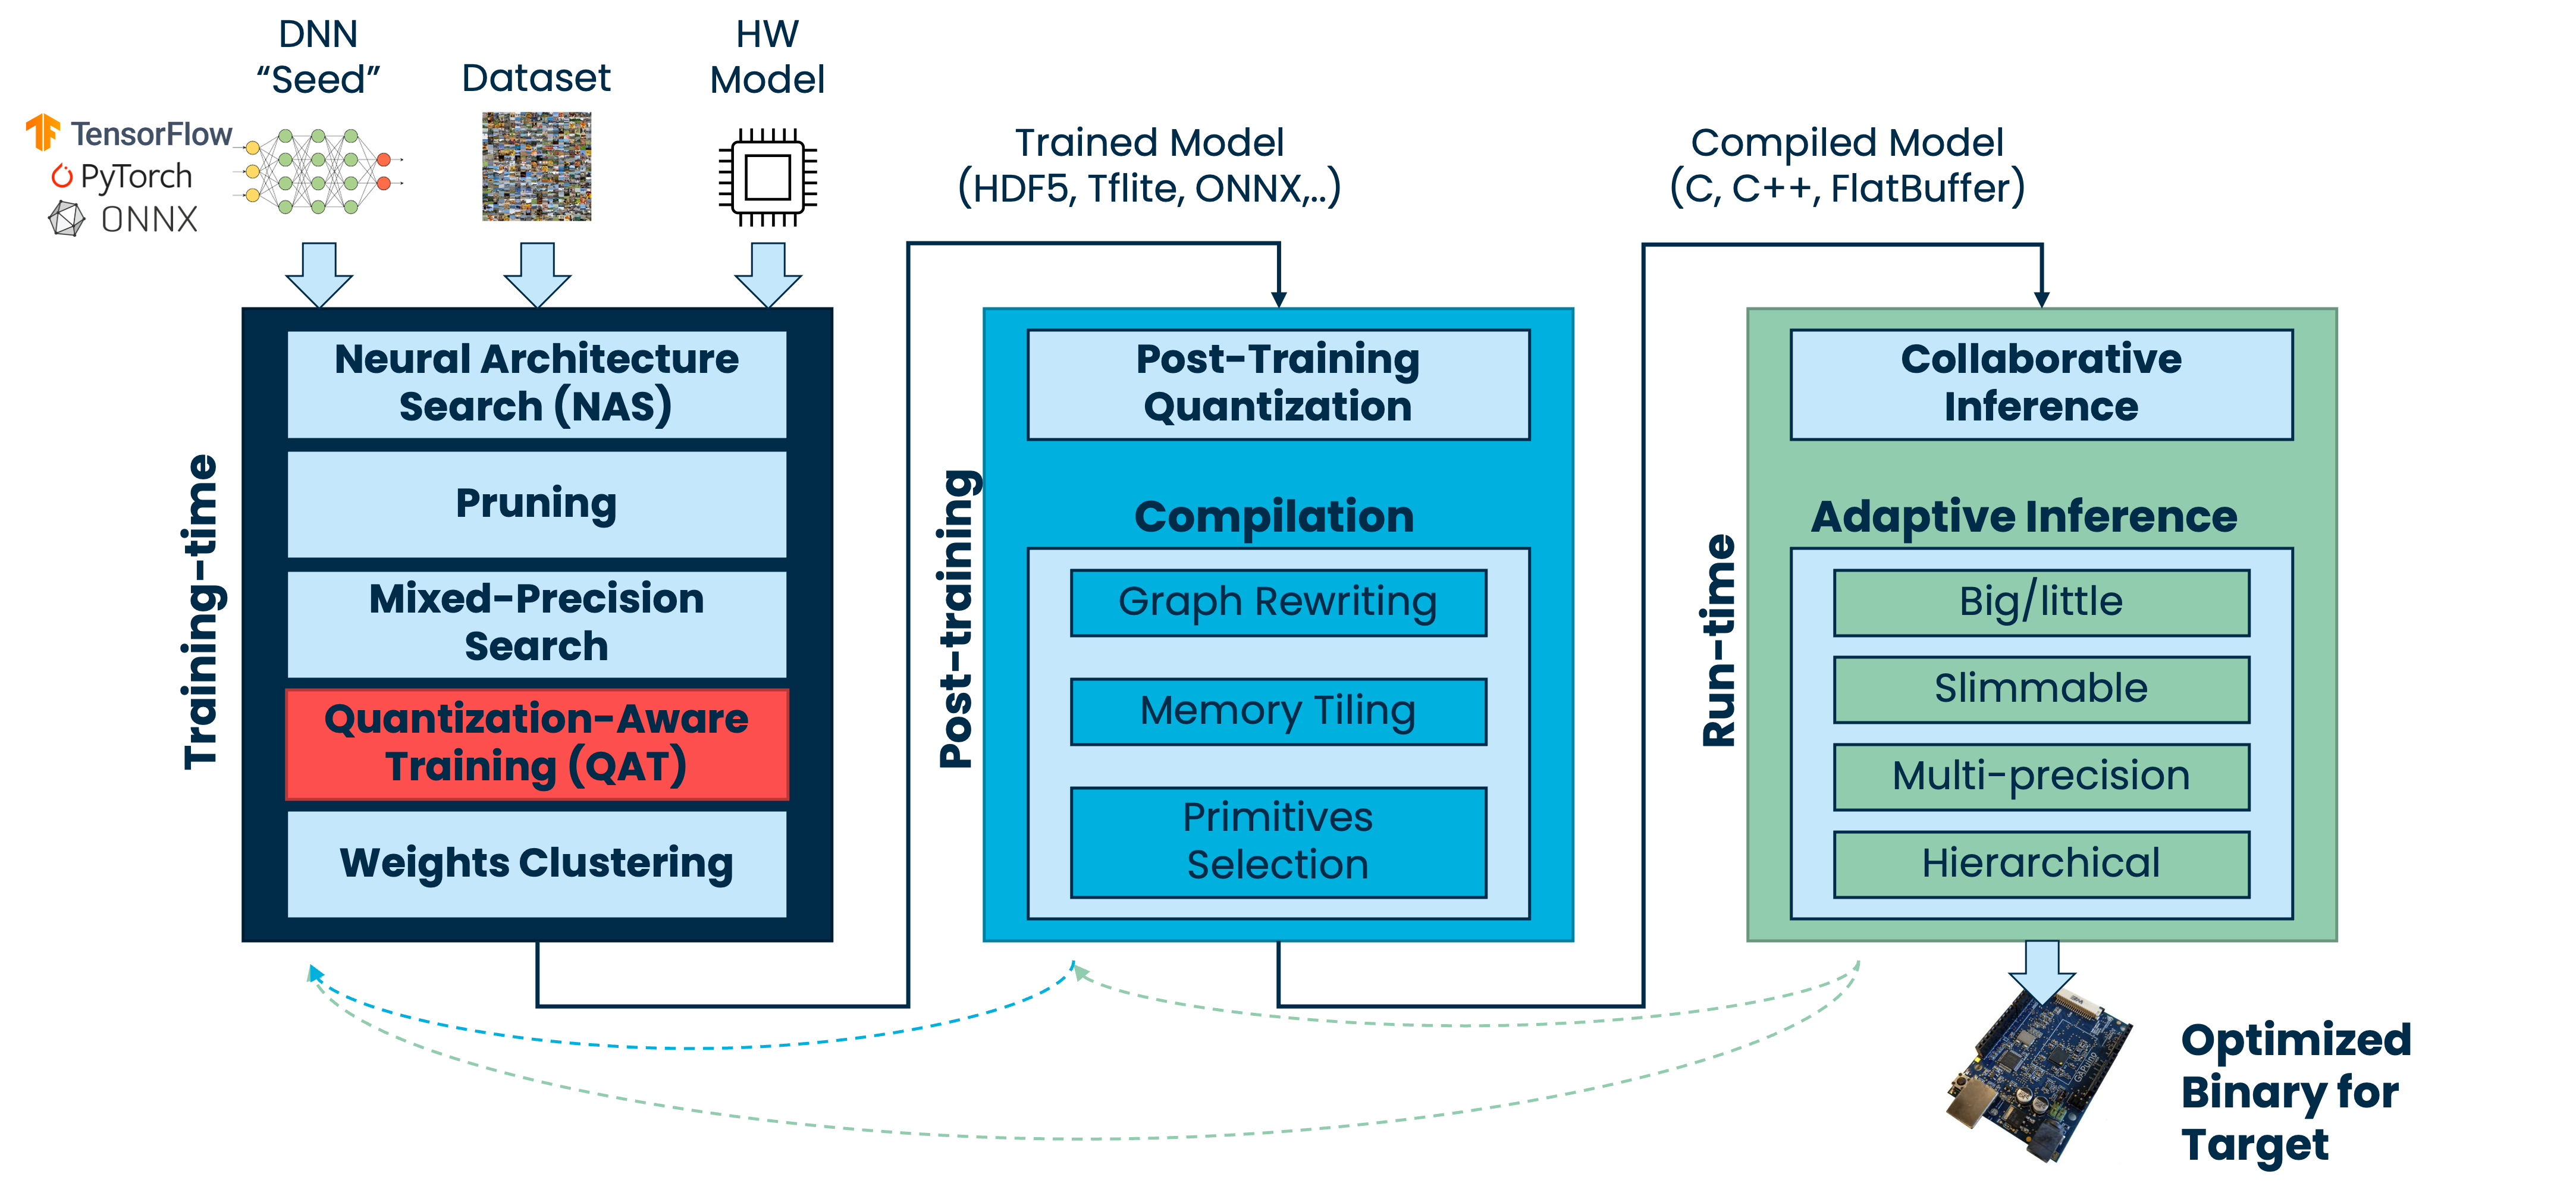

### MPS Quantization-Aware Training on the Original FP Model

On this network, we will apply our MPS gradient-based approach. The next image explain the algorithm to apply layer- and channe- wise quantization. Note that today we will only use layer-wise quantization.

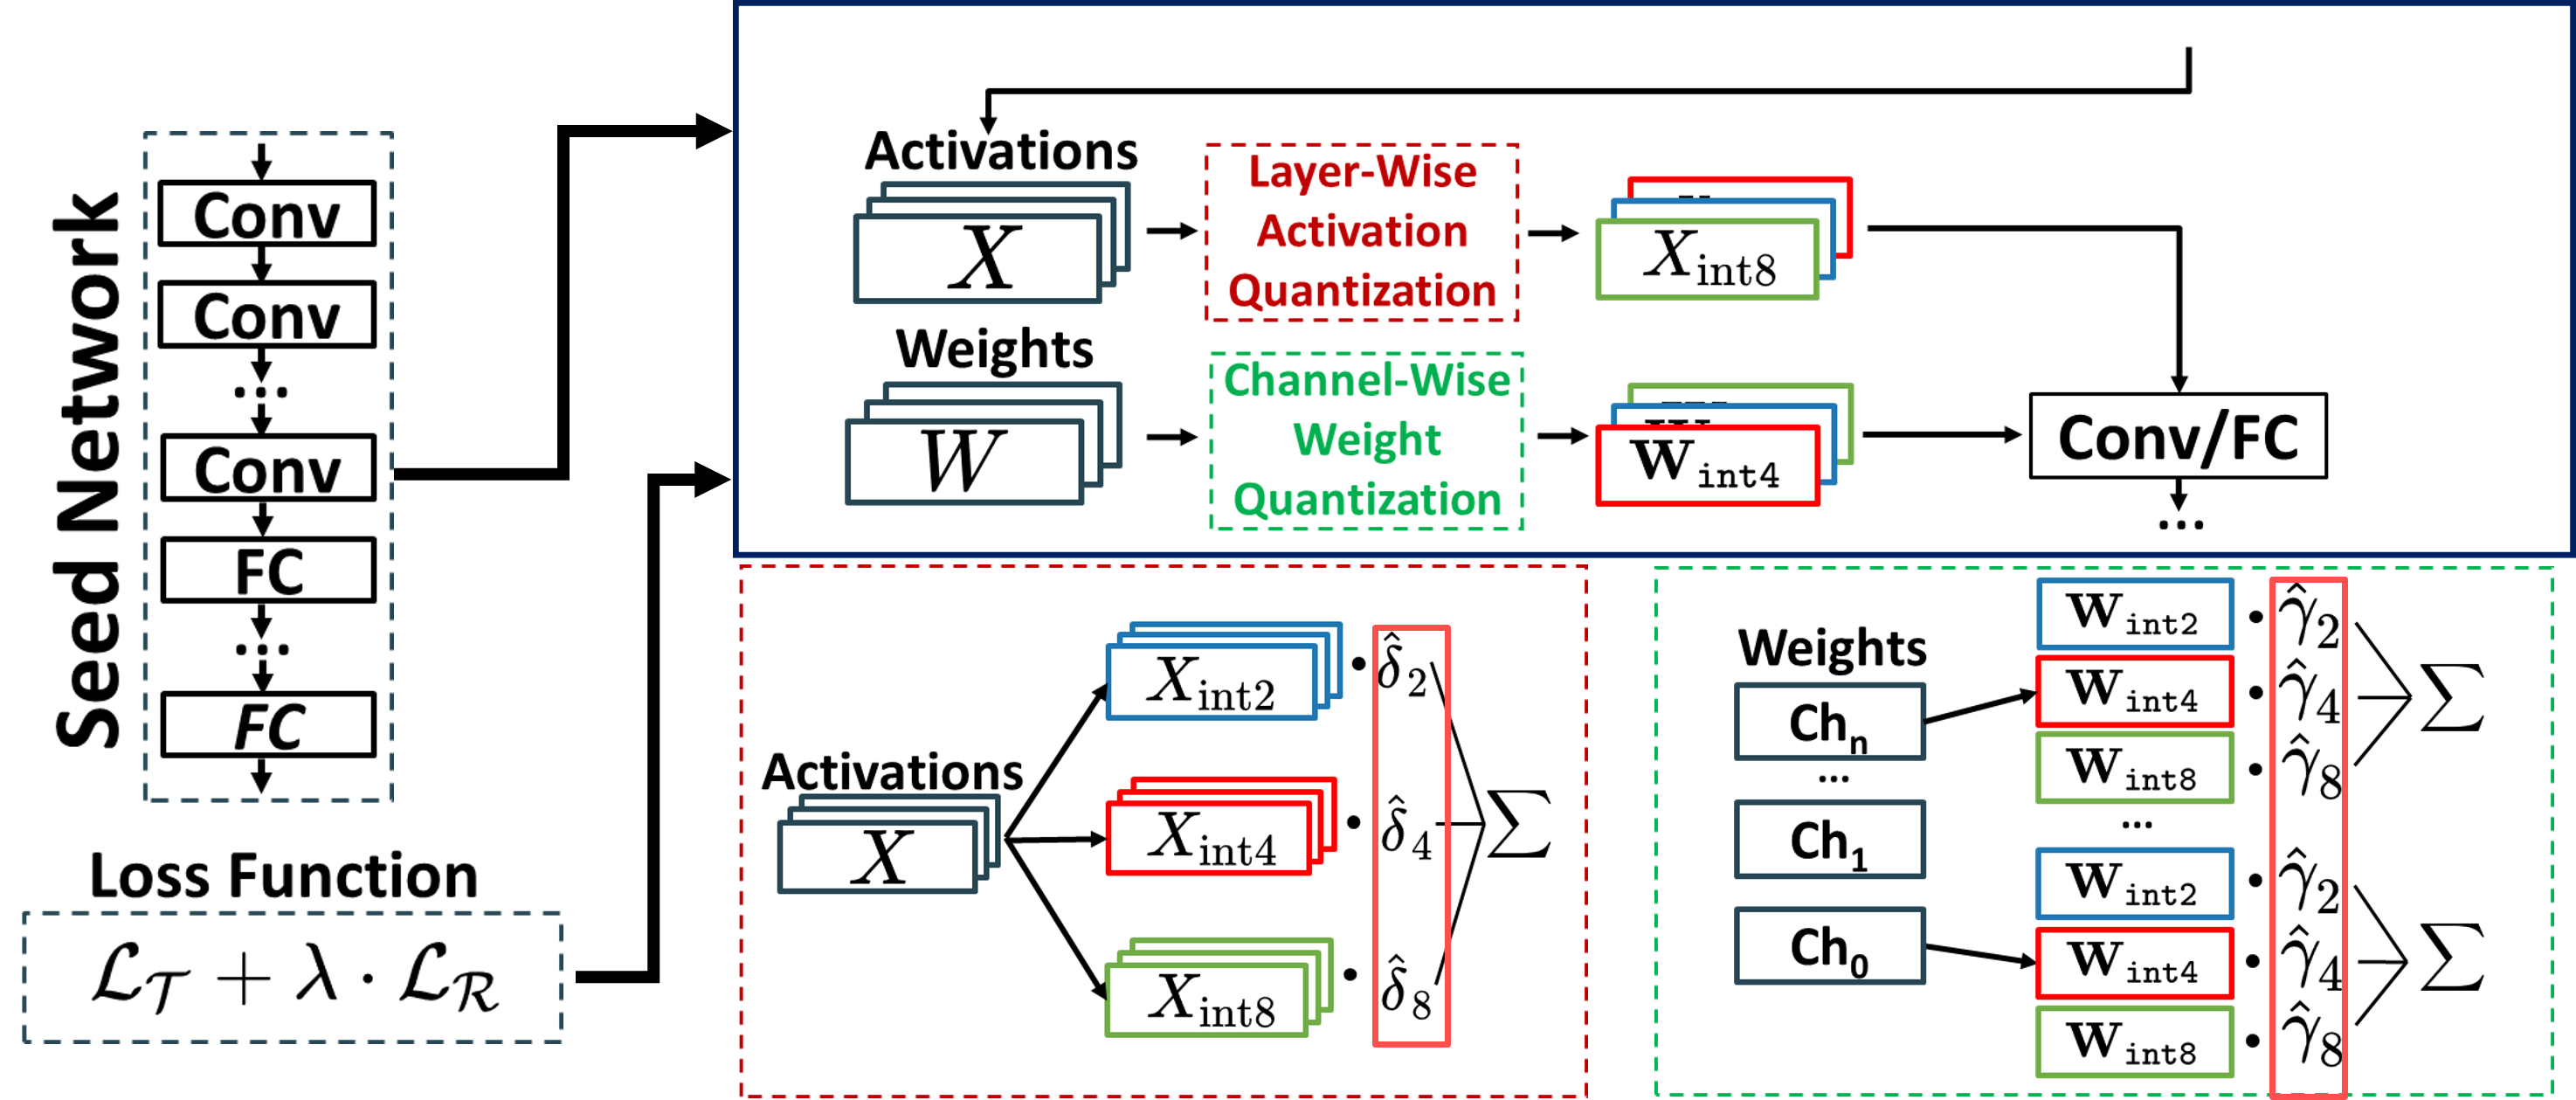

Instantiate the model for mixed precision search.

In [6]:
def alpha_summary(model): 
  """Generates a dictionary representation of the architectural coefficients found by the NAS. Only optimized layers are reported :return: a dictionary representation of the architectural coefficients found by the NAS :rtype: Dict[str, Dict[str, any]]""" 
  arch = {} 
  for name, layer in model.seed.named_modules(): 
    if layer in model._target_layers: 
      prec_dict = {} 
      if isinstance(layer.mixprec_a_quantizer, (MixPrec_Qtz_Layer)): 
        prec_dict['a_precision'] = layer.mixprec_a_quantizer.alpha_prec.detach() 
      if isinstance(layer.mixprec_w_quantizer, (MixPrec_Qtz_Layer)): 
        prec_dict['w_precision'] = layer.mixprec_w_quantizer.alpha_prec.detach() 
      arch[name] = prec_dict 
      arch[name]['type'] = layer.__class__.__name__ 
  return arch

#### Model declaration
We here convert the model using the PLiNIO class MixPrec, to a model where an alfa is associated to the different precisions declared in a_prec and w_prec. A single precion is chosen for each tensor at the end of the search.

In [41]:
import copy
model_to_nas = copy.deepcopy(model)


# Convert the model to PIT
a_prec = (2, 4, 8)
w_prec = (2, 4, 8)
nas_model_mixprec = MixPrec(model_to_nas,
                        input_shape=input_shape,
                        activation_precisions=a_prec,
                        weight_precisions=w_prec,
                        w_mixprec_type=MixPrecType.PER_LAYER)
nas_model_mixprec = nas_model_mixprec.to(device)

criterion = icl.get_default_criterion()
optimizer = torch.optim.Adam(nas_model_mixprec.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = icl.get_default_scheduler(optimizer)

print("Regularization loss:", nas_model_mixprec.get_regularization_loss())
print(nas_model_mixprec)
alpha_summary(nas_model_mixprec)

Regularization loss: tensor(229978.0156, device='cuda:0')
{'block1.conv1.sn_input_layers.0.0': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.0': {'in_a_precision': 2, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.3': {'in_a_precision': 2, 'out_a_p

{'block1.conv1.sn_input_layers.0.0': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor([1., 1., 1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block2.conv1.sn_input_layers.0.0': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor([1., 1., 1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block3.conv1.sn_input_layers.2.0': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor([1., 1., 1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block3.conv1.sn_input_layers.2.3': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor([1., 1., 1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block4.conv1.sn_input_layers.2.0': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor([1., 1., 1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block4.conv1.sn_input_layers.2.3': {'a_precision': tensor([1., 1., 1.], device='cuda:0'),
  'w_precision': tensor

In [8]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_benchmarks.utils import AverageMeter, accuracy

def _run_model(model, image, target, criterion, device):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def train_one_epoch(
        epoch: int,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        train: DataLoader,
        val: DataLoader,
        device: torch.device,
        cd_reg) -> Dict[str, float]:
    model.train()
    avgacc = AverageMeter('6.2f')
    avgloss = AverageMeter('2.5f')
    avglosstask = AverageMeter('2.5f')
    avglossreg = AverageMeter('2.5f')
    step = 0
    with tqdm(total=len(train), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for image, target in train:
            step += 1
            tepoch.update(1)
            image, target = image.to(device), target.to(device)
            output, loss_task = _run_model(model, image, target, criterion, device)
            loss_reg = cd_reg * model.get_regularization_loss()
            loss = loss_task + loss_reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc_val = accuracy(output, target, topk=(1,))
            avgacc.update(acc_val[0], image.size(0))
            avgloss.update(loss, image.size(0))
            avglosstask.update(loss_task, image.size(0))
            avglossreg.update(loss_reg, image.size(0))
            if step % 100 == 99:
                tepoch.set_postfix({'loss': avgloss,
                                    'loss_task': avglosstask,
                                    'loss_reg': avglossreg,
                                    'acc': avgacc})
        val_metrics = icl.evaluate(model, criterion, val, device)
        val_metrics = {'val_' + k: v for k, v in val_metrics.items()}
        final_metrics = {
            'loss': avgloss.get(),
            'loss_task': avglosstask,
            'loss_reg': avglossreg,
            'acc': avgacc.get(),
        }
        final_metrics.update(val_metrics)
        tepoch.set_postfix(final_metrics)
        tepoch.close()
    return final_metrics

#### Training with MPS PLiNIO algorithm

In [42]:
N_EPOCHS = 10
cd_reg = 0
for epoch in range(N_EPOCHS):
    metrics = train_one_epoch(epoch, nas_model_mixprec, criterion, optimizer, train_dl, val_dl, device, cd_reg)
    scheduler.step()
    print(alpha_summary(nas_model_mixprec))
    print(nas_model_mixprec)

Epoch 1: 100%|██████████| 1250/1250 [01:25<00:00, 14.68batch/s, loss=1.97535, loss_task=1.97535, loss_reg=0.00000, acc=23.15]


KeyboardInterrupt: ignored

#### Analyze the network
- Accuracy
- precision
- bits size

In [10]:
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Floating point model: Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print(f"Floating point bit size: {43400*32}") ## bit size computed as size * 32bits
test_metrics = icl.evaluate(nas_model_mixprec, criterion, test_dl, device)
print(f'MPS model: Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print("MPS bit size:", nas_model_mixprec.get_regularization_loss())
print(nas_model_mixprec)

Floating point model: Test Loss: 0.6925619840621948, Test Acc: 75.87999725341797
Floating point bit size: 1388800
MPS model: Test Loss: 4.8212761878967285, Test Acc: 10.0
MPS bit size: tensor(124962., device='cuda:0')
{'block1.conv1.sn_input_layers.0.0': {'in_a_precision': 4, 'out_a_precision': 4, 'w_precision': 4, 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'in_a_precision': 4, 'out_a_precision': 4, 'w_precision': 4, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'in_a_precision': 4, 'out_a_precision': 4, 'w_precision': 4, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'in_a_precision': 4, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_precision': 2, 'w_precision': 2, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2

### 8bits Quantization-Aware Training on the Original FP Model
Given that GAP8 supports only 8bits operation, we will force the MPS algorithm to only use 8bits precision for each tensor.

In [17]:
model_to_nas = copy.deepcopy(model)

# Convert the model to PIT
a_prec = (8, )
w_prec = (8, )
nas_model_8bits = MixPrec(model_to_nas,
                        input_shape=input_shape,
                        activation_precisions=a_prec,
                        weight_precisions=w_prec,
                        w_mixprec_type=MixPrecType.PER_LAYER)
nas_model_8bits = nas_model_8bits.to(device)

criterion = icl.get_default_criterion()
optimizer = torch.optim.Adam(nas_model_8bits.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = icl.get_default_scheduler(optimizer)

print("Regularization loss:", nas_model_8bits.get_regularization_loss())
print(nas_model_8bits)
alpha_summary(nas_model_8bits)

Regularization loss: tensor(394248., device='cuda:0')
{'block1.conv1.sn_input_layers.0.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_preci

{'block1.conv1.sn_input_layers.0.0': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block2.conv1.sn_input_layers.0.0': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block3.conv1.sn_input_layers.2.0': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block3.conv1.sn_input_layers.2.3': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block4.conv1.sn_input_layers.2.0': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block4.conv1.sn_input_layers.2.3': {'a_precision': tensor([1.], device='cuda:0'),
  'w_precision': tensor([1.], device='cuda:0'),
  'type': 'MixPrec_Conv2d'},
 'block5.conv1.sn_input_layers.2.0

#### Training 8bits network with QAT

In [18]:
N_EPOCHS = 10
cd_reg = 5e-7
for epoch in range(N_EPOCHS):
    metrics = train_one_epoch(epoch, nas_model_8bits, criterion, optimizer, train_dl, val_dl, device, cd_reg)
    scheduler.step()
    print(alpha_summary(nas_model_8bits))
    print(nas_model_8bits)

Epoch 1: 100%|██████████| 1250/1250 [01:04<00:00, 19.31batch/s, loss=1.17, loss_task=0.97220, loss_reg=0.19713, acc=66, val_loss=0.849, val_acc=70.7]


{'block1.conv1.sn_input_layers.0.0': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'a_precision': tensor([0.1578], device='cuda:0'), 'w_precision': tensor([0.1578], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block5.conv1.s

Epoch 2: 100%|██████████| 1250/1250 [01:05<00:00, 19.09batch/s, loss=1.11, loss_task=0.91371, loss_reg=0.19713, acc=67.9, val_loss=0.912, val_acc=68]


{'block1.conv1.sn_input_layers.0.0': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'a_precision': tensor([0.0030], device='cuda:0'), 'w_precision': tensor([0.0030], device='cuda:0'), 'type': 'MixPrec_Conv2d'}, 'block5.conv1.s

Epoch 3:  36%|███▌      | 453/1250 [00:21<00:37, 21.48batch/s, loss=1.12471, loss_task=0.92758, loss_reg=0.19712, acc=67.34]


KeyboardInterrupt: ignored

#### Comparison of results
- 8bits
- MPS
- floating point

In [19]:
test_metrics = icl.evaluate(nas_model_8bits, criterion, test_dl, device)
print(f'8bits model: Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print(nas_model_8bits)
test_metrics = icl.evaluate(nas_model_mixprec, criterion, test_dl, device)
print(f'MPS model: Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Floating point model: Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

8bits model: Test Loss: 0.8347165584564209, Test Acc: 70.68000030517578
{'block1.conv1.sn_input_layers.0.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block2.conv1.sn_input_layers.0.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block3.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block4.conv1.sn_input_layers.2.3': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.0': {'in_a_precision': 8, 'out_a_precision': 8, 'w_precision': 8, 'type': 'MixPrec_Conv2d'}, 'block5.conv1.sn_input_layers.2.3': {'in_a_precision

Save the final 8bits model

In [20]:
torch.save(nas_model_8bits, "PIT_Supernet_8bits.pt")

Export

### Full integer model
To run QAT on the floating point model, we first need to create a "quantization-aware" model, i.e., a model with "fake quantization operations", as seen in class. Now, we can integerize that model.

In [21]:
# Convert to (fake) quantized model
quantized_nn = copy.deepcopy(nas_model_8bits).arch_export()
quantized_nn.to(device)
# Dummy inference
with torch.no_grad():
    out_quant = quantized_nn(input_example)

# Test
test_metrics_fq = icl.evaluate(quantized_nn, criterion, test_dl, device)
print(f'Test Loss Fake-Quantized: {test_metrics_fq["loss"]}, Test Acc Fake-Quantized: {test_metrics_fq["acc"]}')

Test Loss Fake-Quantized: 0.8347165584564209, Test Acc Fake-Quantized: 70.68000030517578


Next, let's check if the full-integer models generated above have maintained their accuracy. 

In [25]:
from plinio.methods.mixprec.quant.backends import Backend, integerize_arch
# Convert to integer DORY-compliant model
integer_nn = integerize_arch(copy.deepcopy(quantized_nn).to('cpu'), Backend.DORY)
# integer_nn.to(device)
# Dummy inference
with torch.no_grad():
    out_int = integer_nn(input_example.to('cpu'))
# assert out_quant.argmax() == out_int.argmax()

# Test
test_metrics_int = icl.evaluate(integer_nn, criterion, test_dl, torch.device('cpu'))
print(f'Test Acc Mix-Prec: {test_metrics["acc"]}')
print(f'Test Acc Fake-Quantized: {test_metrics_fq["acc"]}')
# print(f'Test Acc Fake-Quantized Fine-Tune: {test_metrics_fq_ft["acc"]}')
print(f'Test Acc DORY-Integer: {test_metrics_int["acc"]}')

Test Acc Mix-Prec: 75.87999725341797
Test Acc Fake-Quantized: 70.68000030517578
Test Acc DORY-Integer: 70.68000030517578


In [28]:
!mkdir plinio-devel

Finally, we export it to onnx format to be read from DORY compilation tool

In [39]:
from pathlib import Path
from plinio.methods.mixprec.quant.backends.dory import DORYExporter
input_example = input_example.to('cpu')
# Convert and export to ONNX
exporter = DORYExporter()
exporter.export(integer_nn, input_example.shape, Path('./plinio-devel/'), name='TutorialModel')
exporter.dump_features(integer_nn, input_example*255, Path('./plinio-devel/'))

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [40]:
import shutil
shutil.make_archive('plinio-devel', 'zip', 'plinio-devel')

'/content/plinio-devel.zip'